<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2011%3A%20Supply%20Chain%20Analytics/11_4_Network_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supply Chain Analytics**
## Network Optimization

In this case, supply chain network optimization is performed for ABC company. ABC company manufactures 2 different products and the company has four different plants in different locations. Products manufactured in any of the company's plants must be transported to appropriate warehouses and distribution locations in appropriate quantities and taking into account capacity constraints, before reaching customers. Customer demands must be met in all operations. The company, which has five different warehouses, serves 22 customers with 6 different distribution centers. The company aims to design a supply chain network that will minimize the total cost under resource constraints while meeting customer demands. Assumptions related to the case include:

1.	Transportation between facilities has different unit transportation costs.
2.	There is only one route option between facilities.
3.	Each of the warehouses and distribution centers has different operating cost.
4.	Each warehouses and distribution center have a different capacity.
5.	Each customer can demand two products at the same time in different demand quantities.
6.	The total number of distribution centers to be opened cannot be greater than the determined upper limit
7.	The total number of warehouses cannot be greater than a determined up-per limit.
8.	Each customer receives service from only one distribution center.

In [ ]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

     |████████████████████████████████| 9.1 MB 5.3 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to unp

In [ ]:
# import library

import pyomo.environ as pyo
import pandas as pd
import numpy as np

In [ ]:
# Production amount of plants for each production

url='https://docs.google.com/spreadsheets/d/1EfR5dNW7dP-rp8Yvs2RO2s0w1ldSw_qz/edit?usp=sharing&ouid=108589602591644119588&rtpof=true&sd=true'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
#df = pd.read_csv(path) 

production_amount= pd.read_excel(path, index_col=0, sheet_name="plant")
sup = production_amount.iloc[:,:]
sup

,product_1,product_2
P1,200,0
P2,400,0
P3,0,300
P4,0,300


In [ ]:
# Operating costs of warehouses

warehouse = pd.read_excel(path, index_col=0, sheet_name="warehouse")
f= warehouse.iloc[:,0]
f

W1    400000
W2    600000
W3    600000
W4    800000
W5    400000
Name: operating_cost, dtype: int64

In [ ]:
# Capacities of warehouses

warehouse = pd.read_excel(path, index_col=0, sheet_name="warehouse")
T= warehouse.iloc[:,1]
T

W1    100
W2    100
W3    150
W4    200
W5    150
Name: capacity, dtype: int64

In [ ]:
# Operating costs of DCs

DC = pd.read_excel(path, index_col=0, sheet_name="DC")
e= DC.iloc[:,0]
e

DC1    450000
DC2    400000
DC3    500000
DC4    650000
DC5    450000
DC6    500000
Name: operating_cost, dtype: int64

In [ ]:
# Capacity of DCs

DC = pd.read_excel(path, index_col=0, sheet_name="DC")
D= DC.iloc[:,1]
D

DC1    100
DC2    150
DC3    150
DC4    200
DC5    150
DC6    150
Name: capacity, dtype: int64

In [ ]:
# Customer demand for each customer

customer_demand = pd.read_excel(path, index_col=0, sheet_name="customer_demand")
d= customer_demand.iloc[:,[0,1]]
d

,product_1,product_2
C1,15,35
C2,50,10
C3,20,0
C4,0,25
C5,20,10
C6,40,0
C7,10,10
C8,15,35
C9,0,40
C10,15,15


In [ ]:
# Unit transportation cost from plant to warehouse

Transportation_cost_pw = pd.read_excel(path, index_col=0, sheet_name="Transportation_cost_pw")
C_pw = Transportation_cost_pw.iloc[:,:]
C_pw

,W1,W2,W3,W4,W5
P1,2890,21191,47084,41301,13331
P2,46480,51280,65115,63263,35518
P3,57479,56837,62242,68933,46517
P4,41641,36803,35102,40129,37786


In [ ]:
# Unit transportation cost from warehouse to DC

Transportation_cost_wd = pd.read_excel(path, index_col=0, sheet_name="Transportation_cost_wd")
C_wd = Transportation_cost_wd.iloc[:,:]
C_wd

,DC1,DC2,DC3,DC4,DC5,DC6
W1,52830,57177,55930,60768,71050,75170
W2,34875,39260,36009,55967,66249,70369
W3,14123,17903,25501,53813,49012,68215
W4,23989,23686,19112,58802,62053,73204
W5,56572,58916,57631,60541,70823,65002


In [ ]:
# Unit transportation cost from DC to customer

Transportation_cost_dc= pd.read_excel(path, index_col=0, sheet_name="Transportation_cost_dc")
C_dc = Transportation_cost_dc.iloc[:,:]
C_dc

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22
DC1,52452,55552,27239,12773,68971,69764,73771,64057,77778,35593,54682,41490,71579,61373,58878,12174,13858,84582,36274,45421,48370,76757
DC2,73885,40696,0,65795,82049,77702,58878,77098,83675,54531,67761,58311,77551,65795,63301,36992,31435,90592,49352,58500,73733,84809
DC3,79592,19717,22855,47954,101932,97585,37899,96980,103558,71352,87644,77249,97434,64548,62015,43645,35518,110475,69235,78383,81747,104692
DC4,43645,95355,58198,31435,39940,29243,113575,36463,37256,7890,25501,2156,31171,69424,66929,35744,43153,44212,12653,18999,26710,36349
DC5,54380,85414,47840,29318,36009,31662,103595,31057,37634,11695,21721,12892,31511,79706,77173,38390,46404,44552,3648,13052,37445,38768
DC6,46442,104011,66438,45799,30074,16580,122193,26597,22779,21078,18319,15710,21305,83826,81293,50146,57517,30188,18923,16126,31435,18356


In [ ]:
# List of plants

plant = list(production_amount.index)
plant

['P1', 'P2', 'P3', 'P4']

In [ ]:
# List of warehouses

warehouse= list(warehouse.index)
warehouse

['W1', 'W2', 'W3', 'W4', 'W5']

In [ ]:
# List of DCs

DC= list(DC.index)
DC

['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6']

In [ ]:
# List of customers

customer=list(customer_demand.index)
customer

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22']

In [ ]:
product = pd.read_excel(path, sheet_name="plant")
product = product.iloc[:0,1:]
product=list(product)
product

['product_1', 'product_2']

In [ ]:
K=len(warehouse) #maximum number of warehouses in operation
L=len(DC)     #maximum number of DCs in operation

#Decision Variables

**Continous Variables** \\
$X_{jki}$ = number of product $i$ to be shipped from plant $j$ to warehouse store $k$ \\
$Y_{kli}$ = number of product $i$ to be shipped from warehouse $k$ to distribution center (DC) $l$ \\
$Z_{lmi}$ = number of product $i$ to be shipped from DC $l$ to customer $m$ \\

**Binary Variables** \\
$A_l=\begin{cases}
    1, & \text{if DC l is open}.\\
    0, & \text{otherwise}.
  \end{cases}
$

$W_k=\begin{cases}
1, & \text{if warehouse k is open}.\\
    0, & \text{otherwise}.
  \end{cases}$

$B_{lm}=\begin{cases}
1, & \text{if DC l serves to customer m}.\\
    0, & \text{otherwise}.
  \end{cases}$

#Parameters

$T_k:$ Capacity of warehouse $k$ \\
$D_t:$ Capacity of DC $l$ \\
$S_{ji}:$Supply limit of plant $j$ for product $i$ \\
$d_{mi}:$ Demand amount of product $i$ for customer $m$ \\
$e_t:$ Operation cost of DC $l$ \\
$f_k:$ Operation cost of warehouse $k$ \\
$C_{jk}:$ Unit transportation cost from plant $j$ to warehouse $k$ \\
$C_{kl}:$ Unit transportation cost from warehouse $k$ to DC $l$\\
$C_{lm}:$ Unit transportation cost from DC $l$ ro customer $m$ \\
$K:$ Maximum number of warehouses in operation \\
$L:$ Maximum number of DCs in operations

In [ ]:
model = pyo.ConcreteModel()   # Model creating

model.X=pyo.Var(plant,warehouse,product,domain = pyo.NonNegativeReals)  # Quantity of products to be shipped from plants to warehouses
model.Y=pyo.Var(warehouse,DC,product,domain = pyo.NonNegativeReals)   # Quantity of products to be shipped from warehouses to DCs
model.Z=pyo.Var(DC,customer,product,domain = pyo.NonNegativeReals)   # Quantity of products to be shipped from DCs to customers
model.A=pyo.Var(DC,domain=pyo.Binary)     # 1 if DC is open, otherwise 0
model.W=pyo.Var(warehouse, domain=pyo.Binary)       # 1 if warehouse is open, otherwise 0
model.B=pyo.Var(DC,customer,domain=pyo.Binary)   # 1 if DC serves to the customer, otherwise 0

# Objective Function 
$\sum_j \sum_k \sum_i X_{jki} C_{jk} +\sum_k \sum_l \sum_i Y_{kli} C_{kl}+ \sum_l \sum_m \sum_i Z_{lmi} C_{lm}+ \sum_k f_{k} W_{k}+\sum_l e_{l} A_{l}$

In [ ]:
model.obj_val = pyo.Objective(expr = sum(model.X[j,k,i]*C_pw.loc[j,k] for j in plant for k in warehouse for i in product)+
                              sum(model.Y[k,l,i]*C_wd.loc[k,l] for k in warehouse for l in DC for i in product)+
                              sum(model.Z[l,m,i]*C_dc.loc[l,m] for l in DC for m in customer for i in product)+
                              sum(model.W[k]*f[k] for k in warehouse)+sum(model.A[l]*e[l] for l in DC)
)

# **Subject to** 
$\sum_k X_{jki} \leq S_{ji}$ $|$   $\forall$ j and i \\
$\sum_j \sum_i X_{jki} \leq T_{k}W_k$  $|$  $\forall$ k \\
$\sum_l \sum_i X_{kli} \leq T_{k}W_k$   $|$  $\forall$ k \\
$\sum_k \sum_i X_{kli} \leq D_{l}A_l$  $|$   $\forall$ l \\
$\sum_m \sum_i Z_{lmi} \leq D_{l}A_l$   $|$  $\forall$ l \\
$\sum_l A_{l} \leq L$ \\
$\sum_k W_{k} \leq K$ \\
$\sum_j X_{jki} = \sum_l Y_{kli}$ $|$   $\forall$ k and i \\
$\sum_m Z_{lmi} = \sum_k Y_{kli}$ $|$   $\forall$ l and i \\
$\sum_l B_{lm} = 1$ $|$   $\forall$ m \\
$Z_{lmi} = B_{lm} d_{mi}$ $|$   $\forall$ l, m and i \\
$A_{l}, W_{k}, B_{lm} =$ 0 or 1 $|$   $\forall$ k, l and m \\
$X_{jki},Y_{kli},Z_{lmi} \geq 0$ $|$   $\forall$ j, k, l, m and i \\

In [ ]:
# Supply constraint of plants
model.plant_supply = pyo.ConstraintList()

for j in plant: 
  for i in product: 
      model.plant_supply.add(sum(model.X[j,k,i] for k in warehouse) <= sup.loc[j,i])


# Flow in capacity constraint for warehouses
model.warehouse_flowin_capacity = pyo.ConstraintList()

for k in warehouse: 
    model.warehouse_flowin_capacity.add(sum(model.X[j,k,i] for j in plant for i in product) <= (model.W[k]*T[k]))


# Flow out capacity constraint for warehouses
model.warehouse_flowout_capacity=pyo.ConstraintList() 

for k in warehouse: 
  model.warehouse_flowout_capacity.add(sum(model.Y[k,l,i] for l in DC for i in product) <= (model.W[k]*T[k]))


# Flow in capacity constraint for DCs
model.DC_flowin_capacity=pyo.ConstraintList()

for l in DC: 
   model.DC_flowin_capacity.add(sum(model.Y[k,l,i] for k in warehouse for i in product) <= (model.A[l]*D[l]))


#Flow out capacity constraint for DCs
model.DC_flowout_capacity=pyo.ConstraintList()

for l in DC:
  model.DC_flowout_capacity.add(sum(model.Z[l,m,i] for m in customer for i in product ) <= (model.A[l]*D[l]))


# Number of DCs to be opened
model.number_of_DC=pyo.ConstraintList()

model.number_of_DC.add(sum(model.A[l] for l in DC) <= L)


# Number of warehouses to be opened
model.number_of_warehouse=pyo.ConstraintList()

model.number_of_warehouse.add(sum(model.W[k] for k in warehouse) <= K)


# Outflow from a warehouse = Inward flow into the warehouse
model.DC_flowin=pyo.ConstraintList()

for k in warehouse: 
  for i in product: 
    model.DC_flowin.add(sum(model.Y[k,l,i] for l in DC) == sum(model.X[j,k,i] for j in plant))


# Outflow from a DC <= Inward flow into the DC
model.DC_flowout=pyo.ConstraintList()

for l in DC: 
  for i in product: 
    model.DC_flowout.add(sum(model.Z[l,m,i] for m in customer) == sum(model.Y[k,l,i] for k in warehouse))


# Assignment of DC l to the customer m

model.DC_assign=pyo.ConstraintList()
for m in customer:
 model.DC_assign.add(sum(model.B[l,m] for l in DC) == 1)


# Demand satisfaction of customers for each product
model.demand_satisfaction=pyo.ConstraintList() 
for l in DC:
 for m in customer: 
  for i in product: 
    model.demand_satisfaction.add(model.Z[l,m,i] == (model.B[l,m]*d.loc[m,i]))


opt = pyo.SolverFactory("cbc")
opt.solve(model)
for j in plant: 
  for k in warehouse: 
    for i in product:
      if pyo.value(model.X[j,k,i]) > 0:
        print(j,"-",k,"-",i,":",pyo.value(model.X[j,k,i]))

for k in warehouse: 
  for l in DC: 
    for i in product:
      if pyo.value(model.Y[k,l,i]) > 0:
        print(k,"-",l,"-",i,":",pyo.value(model.Y[k,l,i]))

for l in DC: 
  for m in customer: 
    for i in product:
      if pyo.value(model.Z[l,m,i]) > 0:
        print(l,"-",m,"-",i,":",pyo.value(model.Z[l,m,i]))

for l in DC: 
  if pyo.value(model.A[l]) >= 0:
    print(l,":",pyo.value(model.A[l]))

for k in warehouse: 
  if pyo.value(model.W[k]) >= 0:
    print(k,":",pyo.value(model.W[k]))

print("Min Cost:", pyo.value(model.obj_val))



P1 - W1 - product_1 : 100.0
P1 - W2 - product_1 : 55.0
P1 - W5 - product_1 : 45.0
P2 - W4 - product_1 : 110.0
P2 - W5 - product_1 : 25.0
P3 - W5 - product_2 : 50.0
P4 - W2 - product_2 : 45.0
P4 - W3 - product_2 : 150.0
P4 - W4 - product_2 : 75.0
P4 - W5 - product_2 : 30.0
W1 - DC4 - product_1 : 70.0
W1 - DC5 - product_1 : 30.0
W2 - DC1 - product_1 : 45.0
W2 - DC4 - product_1 : 10.0
W2 - DC4 - product_2 : 45.0
W3 - DC1 - product_2 : 50.0
W3 - DC4 - product_2 : 20.0
W3 - DC5 - product_2 : 80.0
W4 - DC3 - product_1 : 110.0
W4 - DC3 - product_2 : 40.0
W4 - DC4 - product_2 : 35.0
W5 - DC4 - product_1 : 15.0
W5 - DC6 - product_1 : 55.0
W5 - DC6 - product_2 : 80.0
DC1 - C4 - product_2 : 25.0
DC1 - C16 - product_1 : 25.0
DC1 - C16 - product_2 : 10.0
DC1 - C17 - product_1 : 20.0
DC1 - C17 - product_2 : 15.0
DC3 - C2 - product_1 : 50.0
DC3 - C2 - product_2 : 10.0
DC3 - C3 - product_1 : 20.0
DC3 - C7 - product_1 : 10.0
DC3 - C7 - product_2 : 10.0
DC3 - C14 - product_1 : 30.0
DC3 - C15 - product_2

# Results 

The company's supply chain network design has been solved using the Python-pyomo library with the parameter values given by establishing an integer programming model. Considering the objective function and constraints in the model created, the total cost are found to be 77738950 and the results obtained for the amount of flow between facilities are presented in the Tables below.

In [ ]:
b1 = []
#Flow quantities from plants to warehouses

for j in plant: 
  for k in warehouse: 
    for i in product:
      if pyo.value(model.X[j,k,i]) > 0:
         b1.append((j,k,i,model.X[j,k,i]()))
                
result_pw = pd.DataFrame(b1, columns=['Plant','Warehouse','Product','Quantity'])

result_pw

,Plant,Warehouse,Product,Quantity
0,P1,W1,product_1,100.0
1,P1,W2,product_1,55.0
2,P1,W5,product_1,45.0
3,P2,W4,product_1,110.0
4,P2,W5,product_1,25.0
5,P3,W5,product_2,50.0
6,P4,W2,product_2,45.0
7,P4,W3,product_2,150.0
8,P4,W4,product_2,75.0
9,P4,W5,product_2,30.0


In [ ]:
b2 = []

#Flow quantities from warehouses to DCs    

for k in warehouse: 
  for l in DC: 
    for i in product:
      if pyo.value(model.Y[k,l,i]) > 0:
         b2.append((k,l,i,model.Y[k,l,i]()))
                
result_wd = pd.DataFrame(b2, columns=['Warehouse','DC','Product','Quantity'])

result_wd

,Warehouse,DC,Product,Quantity
0,W1,DC4,product_1,70.0
1,W1,DC5,product_1,30.0
2,W2,DC1,product_1,45.0
3,W2,DC4,product_1,10.0
4,W2,DC4,product_2,45.0
5,W3,DC1,product_2,50.0
6,W3,DC4,product_2,20.0
7,W3,DC5,product_2,80.0
8,W4,DC3,product_1,110.0
9,W4,DC3,product_2,40.0


In [ ]:
b3 = [] 

#Flow quantities from DCs to customers

for l in DC: 
  for m in customer: 
    for i in product:
      if pyo.value(model.Z[l,m,i]) > 0:
        b3.append((l,m,i,model.Z[l,m,i]()))

result_dc = pd.DataFrame(b3, columns=['DC','Customer','Product','Quantity'])

result_dc


,DC,Customer,Product,Quantity
0,DC1,C4,product_2,25.0
1,DC1,C16,product_1,25.0
2,DC1,C16,product_2,10.0
3,DC1,C17,product_1,20.0
4,DC1,C17,product_2,15.0
5,DC3,C2,product_1,50.0
6,DC3,C2,product_2,10.0
7,DC3,C3,product_1,20.0
8,DC3,C7,product_1,10.0
9,DC3,C7,product_2,10.0


The supply chain design network resulting from the developed model is given in the Figure below.

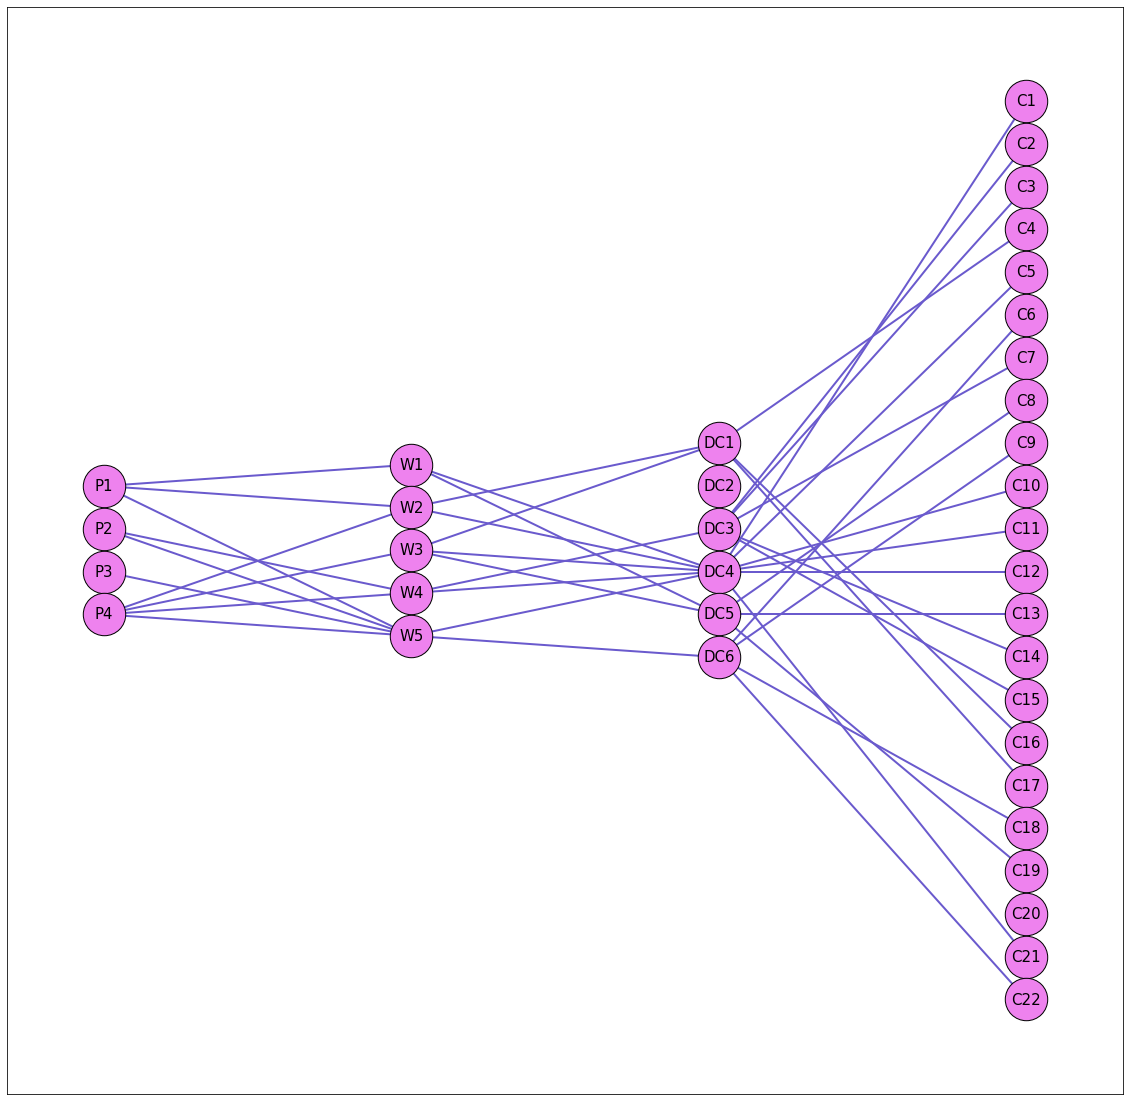

In [ ]:
#Supply chain network 

import matplotlib.pyplot as plt
import networkx as nx

G=nx.Graph()

for j in plant: 
  G.add_node(j,layer=0)
 
for k in warehouse: 
  G.add_node(k,layer=1)

for l in DC: 
  G.add_node(l,layer=2)

for m in customer: 
  G.add_node(m,layer=3)


edge1=[] 
edge2=[]
edge3=[]


for j in plant: 
  for k in warehouse:
    for i in product: 
      if pyo.value(model.X[j,k,i]) > 0:
        edge1.append((j,k))
        G.add_edges_from(list(edge1))
     

for k in warehouse: 
  for l in DC: 
    for i in product:
      if pyo.value(model.Y[k,l,i]) > 0:
        edge2.append((k,l))
        G.add_edges_from(list(edge2)) 

for l in DC: 
  for m in customer: 
    for i in product:
      if pyo.value(model.Z[l,m,i]) > 0:
       edge3.append((l,m))
       G.add_edges_from(list(edge3))


pos = nx.multipartite_layout(G,subset_key="layer",)
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G, pos, edgecolors='black', node_size=1800, node_color='violet')
nx.draw_networkx_labels(G, pos, font_size=15)
nx.draw_networkx_edges(G, pos, node_size=1800, width=2, edge_color='slateblue', arrowsize=100)
plt.show()

The results of transportation and operation costs at each stage are shown in Figure below.

Transportation_cost_pw= 23291820.0
Transportation_cost_wd= 31344445.0
Transportation_cost_dc= 17752685.0
warehouse_operating_cost= 2800000.0
DC_operating_cost= 2550000.0


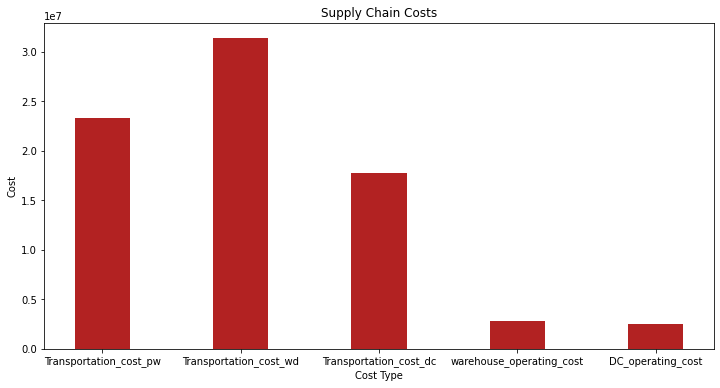

In [ ]:

#Supply chain costs

a=0       
for j in plant: 
  for k in warehouse:
    for i in product: 
      if pyo.value(model.X[j,k,i]) > 0:
        a=a+model.X[j,k,i]()*C_pw.loc[j,k]
Transportation_cost_pw=a

b=0 
for k in warehouse: 
  for l in DC: 
    for i in product:
      if pyo.value(model.Y[k,l,i]) > 0:
        b=b+model.Y[k,l,i]()*C_wd.loc[k,l]
Transportation_cost_wd=b

c=0 
for l in DC: 
  for m in customer: 
    for i in product:
      if pyo.value(model.Z[l,m,i]) > 0:
        c=c+ model.Z[l,m,i]()*C_dc.loc[l,m]
Transportation_cost_dc=c

g=0
for k in warehouse: 
  if pyo.value(model.W[k]) >= 0:
    g=g+model.W[k]()*f[k]
    
warehouse_operating_cost=g

h=0
for l in DC: 
  if pyo.value(model.A[l]) >= 0:
    h=h+model.A[l]()*e[l]
DC_operating_cost=h



print('Transportation_cost_pw=',Transportation_cost_pw)
print('Transportation_cost_wd=',Transportation_cost_wd)
print('Transportation_cost_dc=',Transportation_cost_dc)
print('warehouse_operating_cost=',warehouse_operating_cost)
print('DC_operating_cost=',DC_operating_cost)


x = ['Transportation_cost_pw', 'Transportation_cost_wd', 'Transportation_cost_dc', 'warehouse_operating_cost','DC_operating_cost']
cost = [Transportation_cost_pw, Transportation_cost_wd, Transportation_cost_dc, warehouse_operating_cost, DC_operating_cost]

x_pos = [i for i, _ in enumerate(x)]
fig = plt.figure(figsize = (12, 6))
plt.bar(x_pos, cost, color='firebrick', width = 0.4)
plt.xlabel("Cost Type")
plt.ylabel("Cost")
plt.title("Supply Chain Costs")

plt.xticks(x_pos, x)

plt.show()